# **Irfan Wasway Trading Strategy Backtesting**

For this project, we will be discussing different trading strategies against the S&P 500, and backtesting them to evaluate their effectiveness.

First, let's start by setting up the data and

In [ ]:
# Importing all necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
c_df = pd.read_csv("https://raw.githubusercontent.com/fja05680/sp500/refs/heads/master/S%26P%20500%20Historical%20Components%20%26%20Changes(07-12-2025).csv", index_col=0)
c_df.index = pd.to_datetime(c_df.index)

In [ ]:
def get_tickers_date(c_df, date):
  date = pd.to_datetime(date)
  if date >= c_df.index[-1]:
    ticks = c_df.iloc[-1].tickers
  else:
    ticks = c_df.loc[date:].iloc[0].tickers
  return ticks.split(',')

In [ ]:
df = yf.download(c_df.iloc[-1].tickers.split(','), start='2010-01-01')['Close']

/tmp/ipython-input-2184763733.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(c_df.iloc[-1].tickers.split(','), start='2010-01-01')['Close']
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2025-08-19)')
ERROR:yfinance:['SPGI']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 15604 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
ERROR:yfinance:['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [ ]:
sp = yf.download("^GSPC", start="2010-01-01")["Close"]

/tmp/ipython-input-4157298352.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="2010-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed


Now that we have downloaded all the relevant data, we can start to work on our first strategy.
# 1. Simple Momentum Trading

What we intend to do with this strategy is to buy stocks that have been performing well in the last 12 months, and hold them for a month

In [ ]:
monthly_prices = df.resample('ME').last()
momentum = monthly_prices.pct_change(12).shift(1)

/tmp/ipython-input-906434920.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum = monthly_prices.pct_change(12).shift(1)


Now, we'll use a strategy of picking the top 20% of stocks based on their returns over the last 12 months, each month. We'll hold the stock for a month and rebalance each month.

In [ ]:
momentumWinners_portfolio = pd.DataFrame(index=monthly_prices.index, columns=monthly_prices.columns)

for date in momentum.index[12:]:
  pf_date = momentum.loc[date]
  rel_tickers = get_tickers_date(c_df, date)
  pf_date = pf_date[pf_date.index.isin(rel_tickers)]
  top20 = pf_date.nlargest(100).index
  momentumWinners_portfolio.loc[date,top20] = 1/100

In [ ]:
returns = monthly_prices.pct_change().shift(-1)
momentumWinners_returns = (momentumWinners_portfolio*returns).sum(axis=1)
sp_returns = sp.pct_change()

momentumWinners_returns_cumulative = (1+momentumWinners_returns).cumprod()
sp_returns_cumulative = (1+sp_returns).cumprod()

/tmp/ipython-input-1460647700.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = monthly_prices.pct_change().shift(-1)


We can now compare the portfolio returns with the S&P 500 index returns.

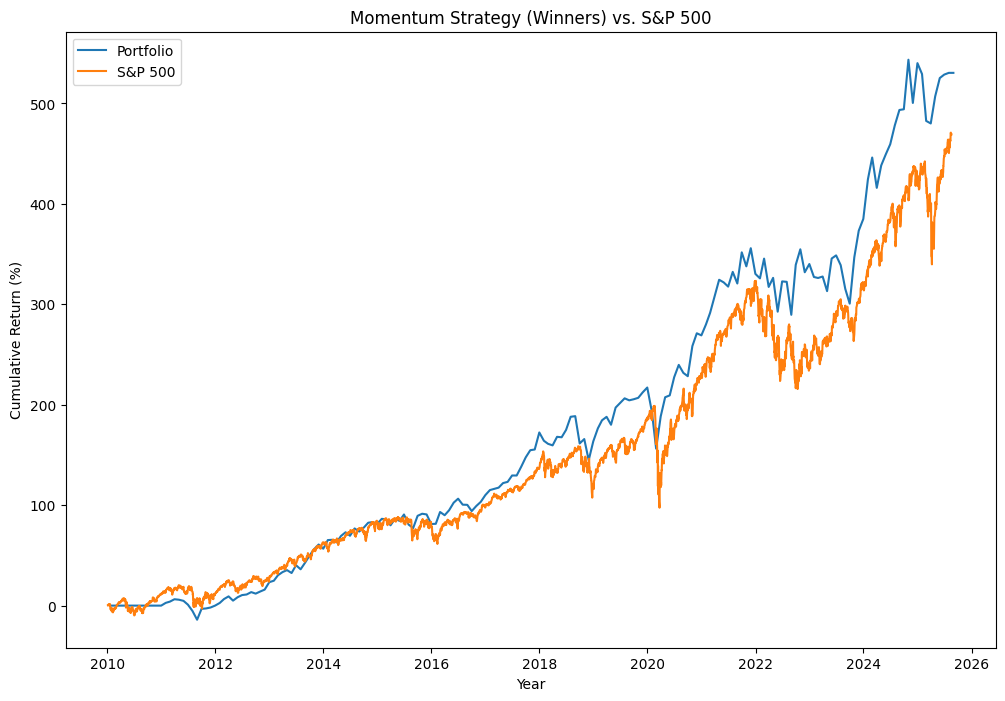

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot((momentumWinners_returns_cumulative-1)*100, label="Portfolio")
plt.plot((sp_returns_cumulative-1)*100, label="S&P 500")
plt.xlabel("Year")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.title("Momentum Strategy (Winners) vs. S&P 500")
plt.show()

Now we can test how much $100 would be, invested in either our momentum strategy or into the S&P 500 index.

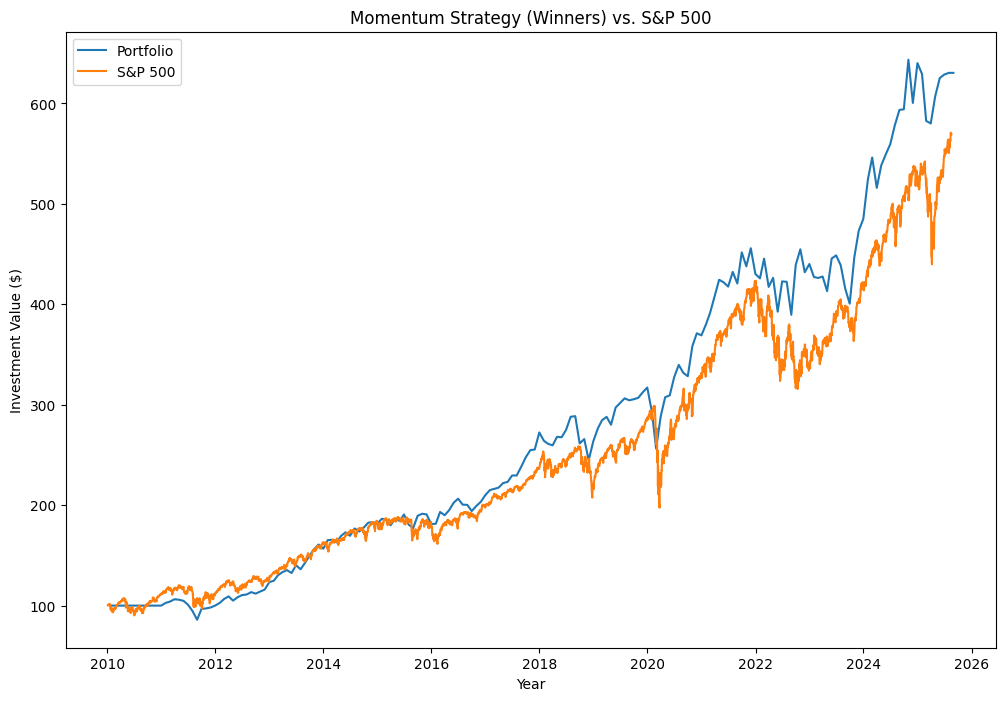

In [ ]:
strategy_pf_value = momentumWinners_returns_cumulative * 100
sp_value = sp_returns_cumulative * 100

plt.figure(figsize=(12, 8))
plt.plot(strategy_pf_value, label="Portfolio")
plt.plot(sp_value, label="S&P 500")
plt.xlabel("Year")
plt.ylabel("Investment Value ($)")
plt.legend()
plt.title("Momentum Strategy (Winners) vs. S&P 500")
plt.show()

We can clearly see that since 2010, our strategy has outperformed the S&P 500. However, this was not consistent over the timeframe, and only slightly edged over the index in more recent times compared to more flucuating results in the past.